In [1]:
import os
import json
import csv
import re
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro, levene, kruskal, mannwhitneyu, ttest_ind
import scikit_posthocs as sp
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

In [5]:
def parse_folder_name(folder_name):
    """
    Улучшенный парсинг имени папки.
    """
    folder_clean = folder_name.split(' ')[0]
    parts = folder_clean.lower().split('-')
    full_name = folder_name.lower()
    
    # Определяем hemisphere по приоритету - СНАЧАЛА ПРОВЕРЯЕМ TRAUMA
    hemisphere = "Unknown"
    hemisphere_reason = ""

    # ПЕРВЫМ ДЕЛОМ ПРОВЕРЯЕМ TRAUMA
    if any(word in full_name for word in ["trauma"]):
        hemisphere = "ipsi"
        hemisphere_reason = "содержит 'trauma'"
    elif any(word in full_name for word in ["contra", "contr", "contrl"]):
        hemisphere = "contralateral"
        hemisphere_reason = "содержит 'contra/contr'"
    elif full_name == "cx43neunsytox-cont-7d-1 contra":
        hemisphere = "contralateral"
        hemisphere_reason = "специальное правило для cx43neunsytox-cont-7d-1 contra"
    else:
        hemisphere_reason = "не найдено ключевых слов"

    # ОПРЕДЕЛЯЕМ EXPERIMENT_TYPE
    experiment_type = "Unknown"
    experiment_reason = ""

    if any(word in full_name for word in ["opit"]):
        experiment_type = "tbi"
        experiment_reason = "содержит 'opit'"    
    elif "control" in full_name:
        experiment_type = "control"
        experiment_reason = "содержит 'control'"
    elif full_name == "cx43neunsytox-cont-7d-1 contra":
        experiment_type = "control"
        experiment_reason = "специальное правило для cx43neunsytox-cont-7d-1 contra"
    else:
        experiment_reason = "не найдено ключевых слов"
    
    # Остальной код остается таким же...
    marker_match = re.search(r'(neun|pv|gfap)', full_name)
    marker = marker_match.group(1).upper() if marker_match else "Unknown"
    
    days = 0
    days_reason = ""
    for part in parts + [full_name]:
        day_match = re.search(r'(\d+)d', part)
        if day_match:
            days = int(day_match.group(1))
            days_reason = f"найдено '{day_match.group(0)}'"
            break
    
    if days == 0:
        days_reason = "дни не найдены"
    
    repetition = ""
    repetition_reason = ""
    if parts and parts[-1].isdigit():
        repetition = parts[-1]
        repetition_reason = "последняя часть папки - цифра"
    elif ' ' in folder_name:
        last_part = folder_name.split()[-1]
        if last_part.isdigit():
            repetition = last_part
            repetition_reason = "последняя часть после пробела - цифра"
    else:
        digit_match = re.search(r'(\d+)', parts[-1])
        if digit_match:
            repetition = digit_match.group(1)
            repetition_reason = f"найдены цифры в последней части: '{digit_match.group(1)}'"
        
    # Применяем захардкоженные правила в КОНЦЕ функции
    hemisphere, experiment_type, hemisphere_reason, experiment_reason = apply_hardcoded_rules(
        folder_name, hemisphere, experiment_type, hemisphere_reason, experiment_reason
    )

    return {
        'original_name': folder_name,
        'marker': marker,
        'days': days,
        'experiment_type': experiment_type,
        'hemisphere': hemisphere,
        'repetition': repetition,
        'parsing_info': {
            'hemisphere_reason': hemisphere_reason,
            'experiment_reason': experiment_reason,
            'days_reason': days_reason,
            'repetition_reason': repetition_reason
        }
    }

def analyze_json_detections(json_data):
    """
    Анализирует JSON данные детекций и возвращает статистику.
    """
    all_detections = []
    
    # JSON может содержать несколько ключей (имен изображений)
    for image_key, detections in json_data.items():
        all_detections.extend(detections)
    
    if not all_detections:
        return {
            'total_cells': 0,
            'gj_count': 0,
            'aggregated_gj_count': 0,
            'avg_width': 0.0,
            'avg_height': 0.0,
            'avg_area': 0.0,
            'gj_avg_width': 0.0,
            'gj_avg_height': 0.0,
            'gj_avg_area': 0.0,
            'aggregated_gj_avg_width': 0.0,
            'aggregated_gj_avg_height': 0.0,
            'aggregated_gj_avg_area': 0.0
        }
    
    # Разделяем на GJ и Aggregated_GJ (учитываем пробел в названии)
    gj_detections = [d for d in all_detections if d.get('label_name') == 'GJ']
    aggregated_gj_detections = [d for d in all_detections if d.get('label_name') in ['Aggregated_GJ', 'Aggregated GJ']]
    
    def calc_stats(detections):
        if not detections:
            return 0.0, 0.0, 0.0
        
        widths = [d.get('bbox_width', 0) for d in detections]
        heights = [d.get('bbox_height', 0) for d in detections]
        areas = [w * h for w, h in zip(widths, heights)]
        
        return (
            sum(widths) / len(widths),
            sum(heights) / len(heights),
            sum(areas) / len(areas)
        )
    
    # Статистика для всех детекций
    all_avg_width, all_avg_height, all_avg_area = calc_stats(all_detections)
    
    # Статистика для GJ
    gj_avg_width, gj_avg_height, gj_avg_area = calc_stats(gj_detections)
    
    # Статистика для Aggregated_GJ
    agg_gj_avg_width, agg_gj_avg_height, agg_gj_avg_area = calc_stats(aggregated_gj_detections)
    
    return {
        'total_cells': len(all_detections),
        'gj_count': len(gj_detections),
        'aggregated_gj_count': len(aggregated_gj_detections),
        'avg_width': all_avg_width,
        'avg_height': all_avg_height,
        'avg_area': all_avg_area,
        'gj_avg_width': gj_avg_width,
        'gj_avg_height': gj_avg_height,
        'gj_avg_area': gj_avg_area,
        'aggregated_gj_avg_width': agg_gj_avg_width,
        'aggregated_gj_avg_height': agg_gj_avg_height,
        'aggregated_gj_avg_area': agg_gj_avg_area
    }

def print_category_analysis(results):
    """
    Выводит анализ категорий для hemisphere и experiment_type
    """
    print(f"\n{'='*80}")
    print(f"📊 АНАЛИЗ КАТЕГОРИЙ HEMISPHERE И EXPERIMENT_TYPE")
    print(f"{'='*80}")
    
    # Группируем по всем возможным комбинациям - ТОЛЬКО УНИКАЛЬНЫЕ ПАПКИ
    categories = defaultdict(set)  # меняем list на set для уникальности
    
    for result in results:
        key = (result['hemisphere'], result['experiment_type'])
        categories[key].add(result['original_name'])  # используем add вместо append
    
    # Выводим группы
    print(f"\n📁 ГРУППИРОВКА ПО КАТЕГОРИЯМ:")
    print(f"{'-'*80}")
    
    for (hemisphere, exp_type), folders in sorted(categories.items()):
        print(f"\n🎯 Категория: hemisphere='{hemisphere}', experiment_type='{exp_type}'")
        print(f"   Количество уникальных папок: {len(folders)}")
        print(f"   Папки:")
        for folder in sorted(folders):
            # Находим информацию о парсинге для этой папки
            parsing_info = next((r['parsing_info'] for r in results if r['original_name'] == folder), {})
            hemisphere_reason = parsing_info.get('hemisphere_reason', 'N/A')
            experiment_reason = parsing_info.get('experiment_reason', 'N/A')
            
            print(f"     - {folder}")
            print(f"       (hemisphere: {hemisphere_reason})")
            print(f"       (experiment: {experiment_reason})")
    
    # Статистика по отдельным категориям - ТОЖЕ ДЛЯ УНИКАЛЬНЫХ ПАПОК
    print(f"\n📈 СТАТИСТИКА ПО КАТЕГОРИЯМ:")
    print(f"{'-'*80}")
    
    hemisphere_stats = defaultdict(set)  
    experiment_stats = defaultdict(set)  
    
    for result in results:
        hemisphere_stats[result['hemisphere']].add(result['original_name'])
        experiment_stats[result['experiment_type']].add(result['original_name'])
    
    print(f"\n🏥 HEMISPHERE:")
    for hemisphere, folders in sorted(hemisphere_stats.items()):
        print(f"   {hemisphere}: {len(folders)} уникальных папок")
    
    print(f"\n🔬 EXPERIMENT_TYPE:")
    for exp_type, folders in sorted(experiment_stats.items()):
        print(f"   {exp_type}: {len(folders)} уникальных папок")

def apply_hardcoded_rules(folder_name, hemisphere, experiment_type, hemisphere_reason, experiment_reason):
    """
    Применяет захардкоженные правила для конкретных имен папок
    """
    full_name = folder_name.lower()
    
    # Добавь сюда все захардкоженные имена
    hardcoded_rules = {
        "cx43gfapsytox-7d-cont-1 contra": {
            'hemisphere': 'contralateral',
            'experiment_type': 'control',
            'hemisphere_reason': 'захардкоженное правило',
            'experiment_reason': 'захардкоженное правило'
        },
        "cx43neunsytox-cont-7d-1 contra": {
            'hemisphere': 'contralateral', 
            'experiment_type': 'control',
            'hemisphere_reason': 'захардкоженное правило',
            'experiment_reason': 'захардкоженное правило'
        }
        # Добавь другие имена по мере необходимости
    }
    
    if full_name in hardcoded_rules:
        rule = hardcoded_rules[full_name]
        return rule['hemisphere'], rule['experiment_type'], rule['hemisphere_reason'], rule['experiment_reason']
    
    return hemisphere, experiment_type, hemisphere_reason, experiment_reason

def process_directories(root_path, output_csv):
    """
    Обрабатывает директории и создает CSV файл с анализом.
    """
    results = []
    stats_summary = {
        'folders': 0,
        'json_files': 0,
        'by_marker': {},
        'by_days': {},
        'by_experiment': {},
        'by_trauma': {},
        'total_detections': 0,
        'total_gj': 0,
        'total_agg_gj': 0
    }
    
    root = Path(root_path)
    
    # Проходим по папкам уровня 2
    for subfolder in root.iterdir():
        if not subfolder.is_dir():
            continue
        
        # Ищем папку Detection
        detection_folder = subfolder / 'Detection'
        if not detection_folder.exists():
            print(f"⚠️  Папка Detection не найдена в {subfolder.name}")
            continue
        
        stats_summary['folders'] += 1
        
        # Парсим имя папки
        metadata = parse_folder_name(subfolder.name)
        
        # Ищем JSON файлы в Detection
        json_files = list(detection_folder.glob('*.json'))
        
        if not json_files:
            print(f"⚠️  JSON файлы не найдены в {detection_folder}")
            continue
        
        # Обрабатываем каждый JSON файл
        for json_file in json_files:
            try:
                with open(json_file, 'r', encoding='utf-8') as f:
                    json_data = json.load(f)
                
                # Анализируем детекции
                stats = analyze_json_detections(json_data)
                
                # Собираем результат
                result = {
                    **metadata,
                    'json_filename': json_file.name,
                    **stats
                }
                
                results.append(result)
                stats_summary['json_files'] += 1
                
                # Собираем статистику
                marker = metadata['marker']
                days = metadata['days']
                exp_type = metadata['experiment_type']
                trauma = metadata['hemisphere']
                
                stats_summary['by_marker'][marker] = stats_summary['by_marker'].get(marker, 0) + 1
                stats_summary['by_days'][days] = stats_summary['by_days'].get(days, 0) + 1
                stats_summary['by_experiment'][exp_type] = stats_summary['by_experiment'].get(exp_type, 0) + 1
                stats_summary['by_trauma'][trauma] = stats_summary['by_trauma'].get(trauma, 0) + 1
                
                stats_summary['total_detections'] += stats['total_cells']
                stats_summary['total_gj'] += stats['gj_count']
                stats_summary['total_agg_gj'] += stats['aggregated_gj_count']
                
                print(f"✓ Обработан: {subfolder.name} -> {json_file.name}")
                
            except Exception as e:
                print(f"❌ Ошибка при обработке {json_file}: {e}")
    
    # Выводим анализ категорий
    if results:
        print_category_analysis(results)
    
    # Записываем CSV (без parsing_info)
    if results:
        fieldnames = [
            'original_name', 'marker', 'days', 'experiment_type', 'hemisphere', 
            'repetition', 'json_filename', 'total_cells', 'gj_count', 
            'aggregated_gj_count', 'avg_width', 'avg_height', 'avg_area',
            'gj_avg_width', 'gj_avg_height', 'gj_avg_area',
            'aggregated_gj_avg_width', 'aggregated_gj_avg_height', 'aggregated_gj_avg_area'
        ]
        
        # Убираем parsing_info из результатов для CSV
        csv_results = []
        for result in results:
            csv_result = {k: v for k, v in result.items() if k != 'parsing_info'}
            csv_results.append(csv_result)
        
        with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(csv_results)
        
        print(f"\n✅ CSV файл создан: {output_csv}")
        print(f"\n{'='*60}")
        print(f"📊 СТАТИСТИКА ОБРАБОТКИ")
        print(f"{'='*60}")
        print(f"Обработано папок: {stats_summary['folders']}")
        print(f"Обработано JSON файлов: {stats_summary['json_files']}")
        print(f"\n📁 По маркерам:")
        for marker, count in sorted(stats_summary['by_marker'].items()):
            print(f"  {marker}: {count} файлов")
        
        print(f"\n📅 По дням:")
        for days, count in sorted(stats_summary['by_days'].items()):
            print(f"  {days}d: {count} файлов")
        
        print(f"\n🔬 По типу эксперимента:")
        for exp, count in sorted(stats_summary['by_experiment'].items()):
            print(f"  {exp}: {count} файлов")
        
        print(f"\n🏥 По типу травмы:")
        for trauma, count in sorted(stats_summary['by_trauma'].items()):
            print(f"  {trauma}: {count} файлов")
        
        print(f"\n🔍 Детекции:")
        print(f"  Всего детекций: {stats_summary['total_detections']}")
        print(f"  GJ: {stats_summary['total_gj']}")
        print(f"  Aggregated GJ: {stats_summary['total_agg_gj']}")
        print(f"{'='*60}\n")
    else:
        print("\n⚠️  Нет данных для записи в CSV")

if __name__ == '__main__':
    # Укажите путь к корневой папке
    root_directory = '.'  # Текущая директория, или укажите путь
    output_csv_path= 'detection_analysis.csv'
    
    process_directories(root_directory, output_csv_path)


✓ Обработан: contra_control_1d_gfap-2 -> 31867_cx43_Z00_bbox.json
✓ Обработан: contra_control_1d_gfap-2 -> 31868_cx43_Z01_bbox.json
✓ Обработан: contra_control_1d_gfap-2 -> 31869_cx43_Z02_bbox.json
✓ Обработан: contra_control_1d_gfap-2 -> 31870_cx43_Z03_bbox.json
✓ Обработан: contra_control_1d_gfap-2 -> 31871_cx43_Z04_bbox.json
✓ Обработан: contra_control_1d_gfap-2 -> 31872_cx43_Z05_bbox.json
✓ Обработан: contra_control_1d_gfap-2 -> 31873_cx43_Z06_bbox.json
✓ Обработан: contra_control_1d_gfap-2 -> 31874_cx43_Z07_bbox.json
✓ Обработан: contra_control_1d_gfap-2 -> 31875_cx43_Z08_bbox.json
✓ Обработан: contra_control_1d_gfap-2 -> 31876_cx43_Z09_bbox.json
✓ Обработан: contra_control_1d_gfap-2 -> 31877_cx43_Z10_bbox.json
✓ Обработан: contra_control_1d_gfap-2 -> 31878_cx43_Z11_bbox.json
✓ Обработан: contra_control_1d_gfap-2 -> 31879_cx43_Z12_bbox.json
✓ Обработан: contra_control_1d_gfap-2 -> 31880_cx43_Z13_bbox.json
✓ Обработан: contra_control_1d_gfap-2 -> 31881_cx43_Z14_bbox.json
✓ Обработа

In [6]:
# Загрузка данных
df = pd.read_csv('detection_analysis.csv')

# Создание групп
groups = {
    'Contra control': df[(df['hemisphere'] == 'contralateral') & 
                         (df['experiment_type'] == 'control')],
    'Ipsi control': df[(df['hemisphere'] == 'ipsi') & 
                       (df['experiment_type'] == 'control') &
                       (df['days'] == 1)],
    'Ipsi TBI 1 day': df[(df['hemisphere'] == 'ipsi') & 
                      (df['experiment_type'] == 'tbi') & 
                      (df['days'] == 1)],
    'Ipsi TBI 7 day': df[(df['hemisphere'] == 'ipsi') & 
                      (df['experiment_type'] == 'tbi') & 
                      (df['days'] == 7)],
}

# Подсчет количества уникальных изображений для каждой группы
for group_name, group_df in groups.items():
    unique_images = group_df['json_filename'].nunique()
    print(f"{group_name}: {unique_images} images")

Contra control: 160 images
Ipsi control: 66 images
Ipsi TBI 1 day: 235 images
Ipsi TBI 7 day: 94 images


In [7]:
df_nonzero = df[df['aggregated_gj_count'] != 0]

df_nonzero.corr(numeric_only=True)

,days,repetition,total_cells,gj_count,aggregated_gj_count,avg_width,avg_height,avg_area,gj_avg_width,gj_avg_height,gj_avg_area,aggregated_gj_avg_width,aggregated_gj_avg_height,aggregated_gj_avg_area
days,1.000000,-0.356948,0.275716,0.179694,0.337193,-0.239524,-0.215104,-0.248782,-0.217895,-0.191815,-0.267414,-0.023211,-0.056952,-0.061967
repetition,-0.356948,1.000000,-0.016633,-0.076642,0.185414,0.079405,0.092437,0.090602,0.104746,0.117279,0.120543,-0.125323,-0.174265,-0.127433
total_cells,0.275716,-0.016633,1.000000,0.951843,0.284567,-0.469777,-0.489935,-0.527977,-0.171411,-0.194142,-0.322944,-0.234371,-0.291974,-0.278685
gj_count,0.179694,-0.076642,0.951843,1.000000,-0.023046,-0.515642,-0.556528,-0.584858,-0.188198,-0.231820,-0.351173,-0.214740,-0.265242,-0.257163
aggregated_gj_count,0.337193,0.185414,0.284567,-0.023046,1.000000,0.080470,0.142581,0.107120,0.029521,0.091804,0.044997,-0.092788,-0.122709,-0.104638
avg_width,-0.239524,0.079405,-0.469777,-0.515642,0.080470,1.000000,0.950657,0.981388,0.693696,0.646912,0.816960,0.654436,0.671801,0.655801
avg_height,-0.215104,0.092437,-0.489935,-0.556528,0.142581,0.950657,1.000000,0.974310,0.661714,0.712035,0.818335,0.666832,0.690247,0.673878
avg_area,-0.248782,0.090602,-0.527977,-0.584858,0.107120,0.981388,0.974310,1.000000,0.627299,0.624330,0.792772,0.629250,0.658380,0.644336
gj_avg_width,-0.217895,0.104746,-0.171411,-0.188198,0.029521,0.693696,0.661714,0.627299,1.000000,0.951468,0.960524,0.547659,0.592559,0.559898
gj_avg_height,-0.191815,0.117279,-0.194142,-0.231820,0.091804,0.646912,0.712035,0.624330,0.951468,1.000000,0.950330,0.557345,0.601741,0.571917


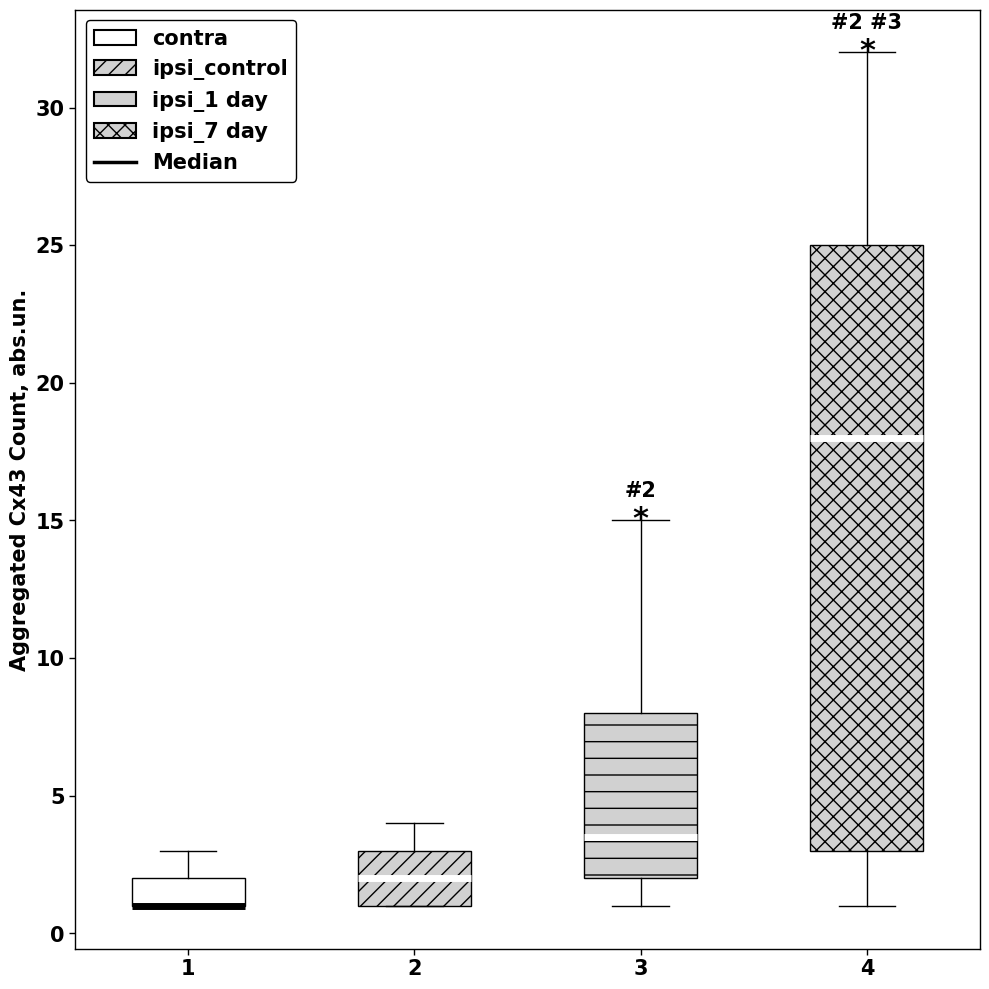

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

# Определяем группы
groups = {
    'Contra control': df_nonzero[(df_nonzero['hemisphere'] == 'contralateral') & 
                                 (df_nonzero['experiment_type'] == 'control')],
    'Ipsi control': df_nonzero[(df_nonzero['hemisphere'] == 'ipsi') & 
                               (df_nonzero['experiment_type'] == 'control') &
                               (df_nonzero['days'] == 1)],
    'Ipsi TBI 1 day': df_nonzero[(df_nonzero['hemisphere'] == 'ipsi') & 
                              (df_nonzero['experiment_type'] == 'tbi') & 
                              (df_nonzero['days'] == 1)],
    'Ipsi TBI 7 day': df_nonzero[(df_nonzero['hemisphere'] == 'ipsi') & 
                              (df_nonzero['experiment_type'] == 'tbi') & 
                              (df_nonzero['days'] == 7)],
}

# Фильтруем только непустые группы
groups = {name: group for name, group in groups.items() if len(group) > 0}

# Создаем чистый график с boxplot - УВЕЛИЧИВАЕМ ВЫСОТУ для вытянутых боксплотов
plt.figure(figsize=(10, 10))
ax = plt.gca()

# Подготовка данных для boxplot
data_gj = [groups[name]['aggregated_gj_count'].values for name in groups.keys()]
group_names = list(groups.keys())

# Позиции для boxplot
positions = np.arange(len(group_names))

# Паттерны для черно-белого стиля
patterns = ['', '//', '-', 'xx']  # пустой, диагональ вправо, диагональ влево, решетка

# Создаем boxplot - УМЕНЬШАЕМ ШИРИНУ для более вытянутого вида
boxplots = ax.boxplot(data_gj, positions=positions, patch_artist=True, 
                     widths=0.5,  # Уменьшено с 0.7 до 0.5 для более узких боксов
                     showmeans=False,
                     showfliers=False,  # Без выбросов для чистоты
                     medianprops={'color': 'white', 'linewidth': 3},
                     whiskerprops={'color': 'black', 'linewidth': 1},  # Тонкие усы
                     capprops={'color': 'black', 'linewidth': 1, 'markersize': 4},  # Тонкие caps
                     boxprops={'edgecolor': 'black', 'linewidth': 1})

# Применяем цвета и паттерны
for i, box in enumerate(boxplots['boxes']):
    if i == 0:  # Contra control - белый
        box.set_facecolor("white")
    else:  # Остальные - светло-серый
        box.set_facecolor("#D1D1D1")
    box.set_edgecolor('black')
    box.set_linewidth(1)
    if i < len(patterns):
        box.set_hatch(patterns[i])

# Настройка медиан — первая чёрная, остальные белые
for i, median in enumerate(boxplots['medians']):
    if i == 0:
        median.set_color('black')
    else:
        median.set_color('white')
    median.set_linewidth(5)
    median.set_zorder(5)  # медиана ниже бокса

# Поднимаем границы боксов, чтобы белая медиана не «резала» их
for box in boxplots['boxes']:
    box.set_zorder(5)

for whisker in boxplots['whiskers']:
    whisker.set_zorder(5)

for cap in boxplots['caps']:
    cap.set_zorder(5)


# Настраиваем параметры паттернов
plt.rcParams['hatch.linewidth'] = 1.0
plt.rcParams['hatch.color'] = 'black'

# Настройка осей координат - тонкие линии
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
# Добавляем верхнюю и правую границы для замыкания прямоугольника
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['top'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')

# ВКЛЮЧАЕМ ЗАСЕЧКИ (TICKS) НА ОСЯХ
ax.tick_params(axis='both', which='major', 
               direction='out',  # Направление засечек наружу
               length=4,         # Длина засечек
               width=1,          # Тонкие засечки
               colors='black',   # Цвет засечек
               labelsize=12)     # Размер шрифта меток
ax.tick_params(bottom=True, top=False, left=True, right=False)

# Добавляем подписи к осям
ax.set_ylabel('Aggregated Cx43 Count, abs.un.', fontsize=15, fontweight='bold')

# ПОДПИСИ СНИЗУ - только цифры от 1 до 4
ax.set_xticks(positions)
ax.set_xticklabels(['1', '2', '3', '4'], fontsize=15, fontweight='bold')

for label in ax.get_yticklabels():
    label.set_fontsize(15)
    label.set_fontweight('bold')
    label.set_color('black')

# Вычисляем средние значения для статистики
means_gj = [np.mean(groups[name]['aggregated_gj_count']) for name in group_names]
sems_gj = [np.std(groups[name]['aggregated_gj_count']) / np.sqrt(len(groups[name])) for name in group_names]

# Добавляем звездочки только над 3 и 4
y_max_3 = max(data_gj[2])  # Группа 3
y_max_4 = max(data_gj[3])  # Группа 4

# Звездочка над группой 3 с #2 над ней
ax.text(2, y_max_3 - 58.5, '*', 
       ha='center', va='bottom', fontsize=22, fontweight='bold', color='black')
ax.text(2, y_max_3 - 57.3, '#2', 
       ha='center', va='bottom', fontsize=15, fontweight='bold', color='black')

# Звездочка над группой 4 с #2, #3 над ней
ax.text(3, y_max_4 - 85.5, '*', 
       ha='center', va='bottom', fontsize=22, fontweight='bold', color='black')
ax.text(3, y_max_4 - 84.3, '#2 #3', 
       ha='center', va='bottom', fontsize=15, fontweight='bold', color='black')

# Легенда для паттернов в левом верхнем углу
legend_elements = []
pattern_labels = ['contra', 'ipsi_control', 'ipsi_1 day', 'ipsi_7 day']

for i, label in enumerate(pattern_labels):
    if i < len(patterns):
        # Contra control белый, остальные светло-серые
        facecolor = "white" if i == 0 else "#D1D1D1"
        patch = plt.Rectangle((0,0), 1, 1, fill=True, 
                             facecolor=facecolor,
                             edgecolor='black', 
                             hatch=patterns[i], 
                             linewidth=1.5)
        legend_elements.append(patch)

# Добавляем элемент медианы в легенду
legend_elements.append(plt.Line2D([0], [0], color='black', linewidth=2.5, label='Median'))

legend = ax.legend(legend_elements, pattern_labels + ['Median'],
                  loc='upper left',  # Левый верхний угол
                  frameon=True,
                  framealpha=1.0,
                  edgecolor='black',
                  facecolor='white',
                  fontsize=15)
for text in legend.get_texts():
    text.set_fontweight('bold')

# Убираем сетку
ax.set_facecolor('white')
ax.grid(False)

# Устанавливаем пределы оси Y (с запасом для звездочек и надписей)
current_ylim = ax.get_ylim()
ax.set_ylim(current_ylim[0], max(current_ylim[1], max(means_gj) + max(sems_gj) + 5))

plt.tight_layout()
plt.savefig('aggregated_cx43_count.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Фильтруем только непустые группы
groups = {name: group for name, group in groups.items() if len(group) > 0}

print("="*80)
print("COMPREHENSIVE STATISTICAL ANALYSIS OF CONNEXIN43 AGGREGATED COUNT")
print("="*80)

# ============================================================================
# 1. DESCRIPTIVE STATISTICS
# ============================================================================
print("\n" + "="*80)
print("1. DESCRIPTIVE STATISTICS")
print("="*80)

for name, group in groups.items():
    data = group['aggregated_gj_count'].values
    n = len(data)
    median = np.median(data)
    q25, q75 = np.percentile(data, [25, 75])
    iqr = q75 - q25
    minimum = np.min(data)
    maximum = np.max(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    
    print(f"\n{name}:")
    print(f"  N = {n}")
    print(f"  Median = {median:.2f} (IQR: {q25:.2f} - {q75:.2f})")
    print(f"  Range: {minimum:.2f} - {maximum:.2f}")
    print(f"  Mean ± SD = {mean:.2f} ± {std:.2f}")

# ============================================================================
# 2. NORMALITY TESTS (Shapiro-Wilk)
# ============================================================================
print("\n" + "="*80)
print("2. NORMALITY TESTS (Shapiro-Wilk)")
print("="*80)

normality_results = {}
for name, group in groups.items():
    data = group['aggregated_gj_count'].values
    w_stat, p_value = shapiro(data)
    normality_results[name] = {'W': w_stat, 'p': p_value}
    print(f"\n{name}:")
    print(f"  W = {w_stat:.4f}, p = {p_value:.4f}")
    if p_value < 0.05:
        print(f"  → Distribution is NOT normal (p < 0.05)")
    else:
        print(f"  → Distribution is normal (p ≥ 0.05)")

# ============================================================================
# 3. HOMOGENEITY OF VARIANCES (Levene's test)
# ============================================================================
print("\n" + "="*80)
print("3. HOMOGENEITY OF VARIANCES (Levene's Test)")
print("="*80)

group_data = [group['aggregated_gj_count'].values for group in groups.values()]
levene_stat, levene_p = levene(*group_data)
print(f"\nLevene's W-statistic = {levene_stat:.4f}, p = {levene_p:.4f}")
if levene_p < 0.05:
    print("  → Variances are NOT equal (p < 0.05)")
else:
    print("  → Variances are equal (p ≥ 0.05)")

# ============================================================================
# 4. KRUSKAL-WALLIS H TEST (main non-parametric test for >2 groups)
# ============================================================================
print("\n" + "="*80)
print("4. KRUSKAL-WALLIS H TEST")
print("="*80)

h_stat, kw_p = kruskal(*group_data)
df_kw = len(groups) - 1
print(f"\nKruskal-Wallis H({df_kw}) = {h_stat:.4f}, p = {kw_p:.6f}")
if kw_p < 0.05:
    print("  → Significant difference between groups (p < 0.05)")
else:
    print("  → No significant difference between groups (p ≥ 0.05)")

# Effect size (eta-squared) from Kruskal-Wallis
n_total = sum(len(g) for g in group_data)
eta_squared = (h_stat - len(groups) + 1) / (n_total - len(groups))
print(f"\nEffect size (η²) = {eta_squared:.4f}")

# ============================================================================
# 5. POST-HOC PAIRWISE COMPARISONS (Mann-Whitney U with Holm correction)
# ============================================================================
print("\n" + "="*80)
print("5. POST-HOC PAIRWISE COMPARISONS (Mann-Whitney U)")
print("="*80)

group_names = list(groups.keys())
comparisons = []
p_values_raw = []
u_statistics = []

# Perform all pairwise comparisons
for i in range(len(group_names)):
    for j in range(i+1, len(group_names)):
        name1 = group_names[i]
        name2 = group_names[j]
        data1 = groups[name1]['aggregated_gj_count'].values
        data2 = groups[name2]['aggregated_gj_count'].values
        
        u_stat, p_val = mannwhitneyu(data1, data2, alternative='two-sided')
        
        comparisons.append(f"{name1} vs {name2}")
        p_values_raw.append(p_val)
        u_statistics.append(u_stat)

# Apply Holm correction
reject, p_corrected, _, _ = multipletests(p_values_raw, method='holm')

print("\nPairwise comparisons with Holm correction:")
print("-" * 80)
for idx, comp in enumerate(comparisons):
    print(f"\n{comp}:")
    print(f"  Mann-Whitney U = {u_statistics[idx]:.2f}")
    print(f"  Unadjusted p = {p_values_raw[idx]:.6f}")
    print(f"  Holm-adjusted p = {p_corrected[idx]:.6f}")
    if p_corrected[idx] < 0.05:
        print(f"  → Significant difference (adjusted p < 0.05)")
    else:
        print(f"  → No significant difference (adjusted p ≥ 0.05)")

# ============================================================================
# 6. EFFECT SIZES (Rank-biserial correlation and Cliff's Delta)
# ============================================================================
print("\n" + "="*80)
print("6. EFFECT SIZES")
print("="*80)

def rank_biserial(u, n1, n2):
    """Calculate rank-biserial correlation"""
    return 1 - (2*u) / (n1 * n2)

def cliffs_delta(x, y):
    """Calculate Cliff's Delta"""
    n1, n2 = len(x), len(y)
    delta = 0
    for xi in x:
        for yi in y:
            if xi > yi:
                delta += 1
            elif xi < yi:
                delta -= 1
    return delta / (n1 * n2)

print("\nEffect sizes for pairwise comparisons:")
print("-" * 80)

for idx, comp in enumerate(comparisons):
    names = comp.split(' vs ')
    data1 = groups[names[0]]['aggregated_gj_count'].values
    data2 = groups[names[1]]['aggregated_gj_count'].values
    n1, n2 = len(data1), len(data2)
    
    # Rank-biserial
    rb = rank_biserial(u_statistics[idx], n1, n2)
    
    # Cliff's Delta
    cd = cliffs_delta(data1, data2)
    
    # Interpret effect size
    if abs(cd) < 0.147:
        interpretation = "negligible"
    elif abs(cd) < 0.33:
        interpretation = "small"
    elif abs(cd) < 0.474:
        interpretation = "medium"
    else:
        interpretation = "large"
    
    print(f"\n{comp}:")
    print(f"  Rank-biserial correlation = {rb:.4f}")
    print(f"  Cliff's Delta = {cd:.4f} ({interpretation} effect)")

# ============================================================================
# 7. CONFIDENCE INTERVALS FOR MEDIANS (Bootstrap)
# ============================================================================
print("\n" + "="*80)
print("7. BOOTSTRAP 95% CI FOR MEDIANS")
print("="*80)

def bootstrap_ci(data, n_bootstrap=5000, ci=95):
    """Bootstrap confidence interval for median"""
    medians = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        medians.append(np.median(sample))
    lower = np.percentile(medians, (100-ci)/2)
    upper = np.percentile(medians, 100-(100-ci)/2)
    return lower, upper

print("\nBootstrap 95% CI for medians (5000 resamples):")
print("-" * 80)

for name, group in groups.items():
    data = group['aggregated_gj_count'].values
    median = np.median(data)
    ci_lower, ci_upper = bootstrap_ci(data)
    print(f"\n{name}:")
    print(f"  Median = {median:.2f}")
    print(f"  95% CI = [{ci_lower:.2f}, {ci_upper:.2f}]")

# ============================================================================
# 8. OUTLIER ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("8. OUTLIER DETECTION (IQR method)")
print("="*80)

print("\nOutliers (values beyond 1.5×IQR):")
print("-" * 80)

for name, group in groups.items():
    data = group['aggregated_gj_count'].values
    q25, q75 = np.percentile(data, [25, 75])
    iqr = q75 - q25
    lower_bound = q25 - 1.5 * iqr
    upper_bound = q75 + 1.5 * iqr
    
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    print(f"\n{name}:")
    print(f"  Lower bound = {lower_bound:.2f}, Upper bound = {upper_bound:.2f}")
    print(f"  Number of outliers = {len(outliers)}")
    if len(outliers) > 0:
        print(f"  Outlier values: {outliers}")

# ============================================================================
# 9. POWER ANALYSIS (post-hoc)
# ============================================================================
print("\n" + "="*80)
print("9. SAMPLE SIZE AND POWER CONSIDERATIONS")
print("="*80)

print("\nCurrent sample sizes:")
for name, group in groups.items():
    print(f"  {name}: N = {len(group)}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")

COMPREHENSIVE STATISTICAL ANALYSIS OF CONNEXIN43 AGGREGATED COUNT

1. DESCRIPTIVE STATISTICS

Contra control:
  N = 38
  Median = 1.00 (IQR: 1.00 - 2.00)
  Range: 1.00 - 18.00
  Mean ± SD = 2.16 ± 3.12

Ipsi control:
  N = 18
  Median = 2.00 (IQR: 1.00 - 3.00)
  Range: 1.00 - 4.00
  Mean ± SD = 2.00 ± 1.08

Ipsi TBI 1 day:
  N = 86
  Median = 3.50 (IQR: 2.00 - 8.00)
  Range: 1.00 - 73.00
  Mean ± SD = 5.87 ± 8.37

Ipsi TBI 7 day:
  N = 59
  Median = 18.00 (IQR: 3.00 - 25.00)
  Range: 1.00 - 117.00
  Mean ± SD = 19.86 ± 19.67

2. NORMALITY TESTS (Shapiro-Wilk)

Contra control:
  W = 0.3850, p = 0.0000
  → Distribution is NOT normal (p < 0.05)

Ipsi control:
  W = 0.8194, p = 0.0029
  → Distribution is NOT normal (p < 0.05)

Ipsi TBI 1 day:
  W = 0.4679, p = 0.0000
  → Distribution is NOT normal (p < 0.05)

Ipsi TBI 7 day:
  W = 0.7303, p = 0.0000
  → Distribution is NOT normal (p < 0.05)

3. HOMOGENEITY OF VARIANCES (Levene's Test)

Levene's W-statistic = 12.2682, p = 0.0000
  → Varianc